In [79]:
import scprep, scipy, graphtools, leidenalg, magic
import scanpy as sc
import pandas as pd
import numpy as np
import phate
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.preprocessing import scale
from scipy import io
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats

In [5]:
sdata = sc.read_h5ad('../processed_files/3_primate_all_cell_types_all_genes.h5ad')

## Leiden clustering

In [7]:
G = graphtools.Graph(sdata.obsm["X_pca_bmc"], use_pygsp=True, n_pca=None, random_state=42, sample_idx=sdata.obs.batch, bandwidth_scale=0.5)

In [13]:
sdata.obs['clusters_res_0.1'] = np.array(partition.membership).astype('str')
sdata.obs['clusters_res_0.1'] = scprep.utils.sort_clusters_by_values(sdata.obs['clusters_res_0.1'], sdata.obsm['X_phate_mnn_bmc'][:, 0]).astype(str)

In [14]:
partition = leidenalg.find_partition(G.to_igraph(), leidenalg.RBConfigurationVertexPartition, seed=0,
                                     weights="weight", resolution_parameter=0.1, n_iterations=-1)

In [ ]:
# reannotated primate genes from BioMart
genes = pd.read_csv('../data/reannotated_gene_names.csv', index_col=0)

sdata.var['reannotated_gene_names'] = genes['reannotated_gene_names'].loc[sdata.var_names]
sdata.var['primate_annotated'] = [x.startswith('ENSMMUG') for x in sdata.var['reannotated_gene_names']]

In [16]:
cluster_conv = {'0': '1', '1': '1', '2':'2', '3':'3', '4':'4'}
sdata.obs['clusters_res_0.1'] = [cluster_conv[x] for x in sdata.obs['clusters_res_0.1']]

<Axes: title={'center': 'Primate all cells\nClusters'}, xlabel='PHATE1', ylabel='PHATE2'>

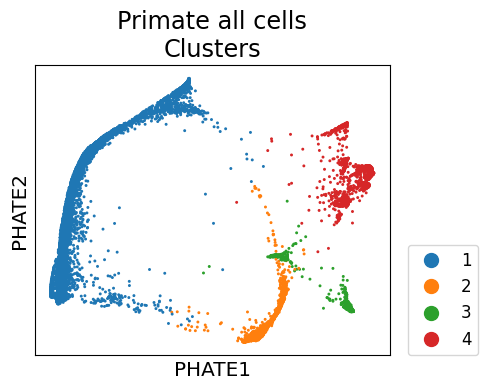

In [17]:
scprep.plot.scatter2d(sdata.obsm['X_phate_mnn_bmc'], c=sdata.obs['clusters_res_0.1'], legend_loc=(1.05,0), ticks=None,
                      label_prefix='PHATE', dpi=200, figsize=(5,4), filename='figures/primate_all_cells/clusters.png', 
                      title='Primate all cells\nClusters')

<Axes: title={'center': 'Primate all cells\nPTH'}, xlabel='PHATE1', ylabel='PHATE2'>

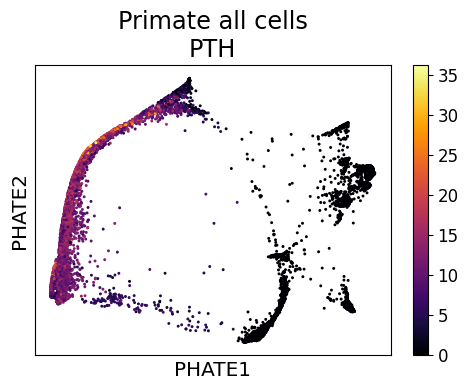

In [18]:
scprep.plot.scatter2d(sdata.obsm['X_phate_mnn_bmc'], c=sdata[:, sdata.var['reannotated_gene_names'] == 'PTH'].to_df(),
                      legend_loc=(1.05,0), ticks=None, label_prefix='PHATE', dpi=200, figsize=(5,4), 
                      filename='figures/primate_all_cells/PTH.png', title='Primate all cells\nPTH')

## PyDESeq

In [20]:
# DESeq operates on the raw measurements

sdata.layers['decontx'] = io.mmread('../intermediate_files/2_decontx_primate_data.mtx').T
sdata.layers['decontx'] = scipy.sparse.csr_matrix(sdata.layers['decontx'])
sdata.layers['decontx'] = sdata.layers['decontx'].astype(int)

In [45]:
# only DEG analysis on human-annotated genes
sdata = sdata[:, ~sdata.var['primate_annotated']]
sdata.var_names = sdata.var['gene_ids']

In [46]:
pbs = []
for sample in sdata.obs['sample'].unique():
    for cluster in sdata.obs['clusters_res_0.1'].unique():
        sdata_subset = sdata[sdata.obs['sample'] == sample]
        samp_cell_subset = sdata_subset[sdata_subset.obs['clusters_res_0.1'] == cluster]
        samp_cell_subset.X = samp_cell_subset.layers['decontx']

        rep_adata = sc.AnnData(X = samp_cell_subset.X.sum(axis=0), var=samp_cell_subset.var[[]])
        rep_adata.obs['sample'] = sample
        rep_adata.obs['cluster'] = int(cluster)
        pbs.append(rep_adata)

In [47]:
pb = sc.concat(pbs)
pb.obs_names = range(16)
counts = pd.DataFrame(pb.X, columns = pb.var_names)

for cluster in [1,2,3,4]:
    pb.obs[f'in_cluster_{cluster}_vs_1'] = pb.obs['cluster'].isin([cluster])
for sample in ['sample2', 'sample3', 'sample4']:
    pb.obs[f'in_{sample}_vs_sample1'] = pb.obs['sample'].isin([sample])

/gpfs/gibbs/project/krishnaswamy_smita/av622/conda_envs/gspa/lib/python3.8/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [48]:
for cluster in [1,2,3,4]:
    dds = DeseqDataSet(counts=counts, metadata=pb.obs, 
                   design_factors=[f'in_cluster_{cluster}_vs_1', 'in_sample2_vs_sample1', 'in_sample3_vs_sample1', 'in_sample4_vs_sample1'])
    dds.deseq2()
    stat_res = DeseqStats(dds, n_cpus=8, contrast=(f'in-cluster-{cluster}-vs-1', 'True', 'False'))
    stat_res.summary()
    df = stat_res.results_df
    df = df[(df['log2FoldChange'] > 0) & (df['padj'] < 0.05)].sort_values('log2FoldChange', ascending=False)

    df['gene_name'] = sdata.var.loc[df.index]['reannotated_gene_names']
    df.to_csv(f'results/primate_all_cells/pseudobulk_cluster_{cluster}_vs_rest.csv')

/gpfs/gibbs/project/krishnaswamy_smita/av622/conda_envs/gspa/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/tmp/ipykernel_471946/2350624874.py:2: UserWarning: Same factor names in the design contain underscores ('_'). They will
                be converted to hyphens ('-').
  dds = DeseqDataSet(counts=counts, metadata=pb.obs,
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 18.19 seconds.

Fitting dispersion trend curve...
... done in 5.77 seconds.

/gpfs/gibbs/project/krishnaswamy_smita/av622/conda_envs/gspa/lib/python3.8/site-packages/anndata/_core/views.py:113: RuntimeWarning: invalid value encountered in log
  results = super().__array_ufunc__(
Fitting MAP dispersions...
... done in 29.76 seconds.

/gpfs/gibbs/project/krishnaswamy_smita/av622/conda_envs/gspa/lib/python3.8/site-packages/pydeseq2/dds.py:695

Log2 fold change & Wald test p-value: in-cluster-1-vs-1 True vs False


... done in 8.53 seconds.



,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
gene_ids,,,,,,
ENSMMUG00000000634,0.191376,-1.235345,1.421907,-0.868794,0.384960,0.503295
ENSMMUG00000037875,1.897190,0.820842,0.635895,1.290845,0.196757,0.312184
ENSMMUG00000000632,0.983682,-1.374592,0.835144,-1.645934,0.099777,0.215469
ENSMMUG00000057389,0.000000,NaN,NaN,NaN,NaN,NaN
ENSMMUG00000038524,0.000000,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
ENSMMUG00000050414,0.025698,-2.836106,3.574407,-0.793448,0.427517,0.546180
ENSMMUG00000063497,0.004895,-5.235048,3.642201,-1.437331,0.150624,0.265849
ENSMMUG00000060105,0.454961,-0.915496,1.523575,-0.600887,0.547915,0.654186


/gpfs/gibbs/project/krishnaswamy_smita/av622/conda_envs/gspa/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/tmp/ipykernel_471946/2350624874.py:2: UserWarning: Same factor names in the design contain underscores ('_'). They will
                be converted to hyphens ('-').
  dds = DeseqDataSet(counts=counts, metadata=pb.obs,
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 17.74 seconds.

Fitting dispersion trend curve...
... done in 5.77 seconds.

/gpfs/gibbs/project/krishnaswamy_smita/av622/conda_envs/gspa/lib/python3.8/site-packages/anndata/_core/views.py:113: RuntimeWarning: invalid value encountered in log
  results = super().__array_ufunc__(
Fitting MAP dispersions...
... done in 28.21 seconds.

/gpfs/gibbs/project/krishnaswamy_smita/av622/conda_envs/gspa/lib/python3.8/site-packages/pydeseq2/dds.py:695

Log2 fold change & Wald test p-value: in-cluster-2-vs-1 True vs False


,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
gene_ids,,,,,,
ENSMMUG00000000634,0.191376,0.237112,1.632218,0.145270,0.884498,NaN
ENSMMUG00000037875,1.897190,-0.588212,0.829095,-0.709462,0.478038,0.754637
ENSMMUG00000000632,0.983682,-0.715550,1.345274,-0.531899,0.594796,0.815021
ENSMMUG00000057389,0.000000,NaN,NaN,NaN,NaN,NaN
ENSMMUG00000038524,0.000000,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
ENSMMUG00000050414,0.111202,-1.238055,3.866052,-0.320238,0.748788,NaN
ENSMMUG00000063497,0.004895,-0.872039,3.892105,-0.224053,0.822716,NaN
ENSMMUG00000060105,0.454961,-1.330292,2.001441,-0.664667,0.506263,NaN


/gpfs/gibbs/project/krishnaswamy_smita/av622/conda_envs/gspa/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/tmp/ipykernel_471946/2350624874.py:2: UserWarning: Same factor names in the design contain underscores ('_'). They will
                be converted to hyphens ('-').
  dds = DeseqDataSet(counts=counts, metadata=pb.obs,
Fitting size factors...
... done in 0.02 seconds.

Fitting dispersions...
... done in 20.22 seconds.

Fitting dispersion trend curve...
... done in 11.79 seconds.

/gpfs/gibbs/project/krishnaswamy_smita/av622/conda_envs/gspa/lib/python3.8/site-packages/anndata/_core/views.py:113: RuntimeWarning: invalid value encountered in log
  results = super().__array_ufunc__(
Fitting MAP dispersions...
... done in 30.46 seconds.

/gpfs/gibbs/project/krishnaswamy_smita/av622/conda_envs/gspa/lib/python3.8/site-packages/pydeseq2/dds.py:69

Log2 fold change & Wald test p-value: in-cluster-3-vs-1 True vs False


,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
gene_ids,,,,,,
ENSMMUG00000000634,0.191376,1.276344,2.010475,0.634847,0.525528,NaN
ENSMMUG00000037875,1.897190,-0.446834,1.393573,-0.320639,0.748484,0.870153
ENSMMUG00000000632,0.983682,1.536567,1.437677,1.068785,0.285167,NaN
ENSMMUG00000057389,0.000000,NaN,NaN,NaN,NaN,NaN
ENSMMUG00000038524,0.000000,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
ENSMMUG00000050414,0.111202,1.654870,3.839976,0.430958,0.666499,NaN
ENSMMUG00000063497,0.004895,2.212303,3.866390,0.572188,0.567194,NaN
ENSMMUG00000060105,0.454961,2.249831,1.612362,1.395364,0.162906,NaN


/gpfs/gibbs/project/krishnaswamy_smita/av622/conda_envs/gspa/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/tmp/ipykernel_471946/2350624874.py:2: UserWarning: Same factor names in the design contain underscores ('_'). They will
                be converted to hyphens ('-').
  dds = DeseqDataSet(counts=counts, metadata=pb.obs,
Fitting size factors...
... done in 0.02 seconds.

Fitting dispersions...
... done in 19.22 seconds.

Fitting dispersion trend curve...
... done in 11.74 seconds.

/gpfs/gibbs/project/krishnaswamy_smita/av622/conda_envs/gspa/lib/python3.8/site-packages/anndata/_core/views.py:113: RuntimeWarning: invalid value encountered in log
  results = super().__array_ufunc__(
Fitting MAP dispersions...
... done in 30.11 seconds.

/gpfs/gibbs/project/krishnaswamy_smita/av622/conda_envs/gspa/lib/python3.8/site-packages/pydeseq2/dds.py:69

Log2 fold change & Wald test p-value: in-cluster-4-vs-1 True vs False


,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
gene_ids,,,,,,
ENSMMUG00000000634,0.191376,0.085736,2.024765,0.042344,0.966225,NaN
ENSMMUG00000037875,1.897190,-0.770204,1.072767,-0.717960,0.472782,0.768311
ENSMMUG00000000632,0.983682,1.649654,1.089499,1.514140,0.129990,0.399447
ENSMMUG00000057389,0.000000,NaN,NaN,NaN,NaN,NaN
ENSMMUG00000038524,0.000000,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
ENSMMUG00000050414,0.111202,0.402957,3.912023,0.103005,0.917959,NaN
ENSMMUG00000063497,0.004895,0.873433,3.926105,0.222468,0.823949,NaN
ENSMMUG00000060105,0.454961,0.136541,1.990459,0.068598,0.945310,NaN


In [62]:
sdata.raw.var.index = sdata.raw.var['gene_ids']
sdata.X = sdata.raw[:, sdata.var_names].X

## Visualize DEGs

In [73]:
de_gene_set_vis = []
names_for_dotplot = []
num_vis = 8
for cluster in range(1,sdata.obs['clusters_res_0.1'].unique().shape[0]+1):
    df = pd.read_csv(f'results/primate_all_cells/pseudobulk_cluster_{cluster}_vs_rest.csv', index_col=0)
    degs = df.sort_values('log2FoldChange', ascending=False).iloc[:20].index.tolist()
    if len(set(df.loc[degs[:num_vis]]['gene_name'].tolist())) < 8:
        de_gene_set_vis.extend(df.loc[degs[:num_vis+1]]['gene_name'].drop_duplicates().index.tolist())
        names_for_dotplot.extend(df.loc[degs[:num_vis+1]]['gene_name'].drop_duplicates().tolist())
    else:
        de_gene_set_vis.extend(degs[:num_vis])
        names_for_dotplot.extend(df.loc[degs[:num_vis]]['gene_name'].tolist())

In [74]:
sns.set(font_scale=1.4, style='white')

/gpfs/gibbs/project/krishnaswamy_smita/av622/conda_envs/gspa/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


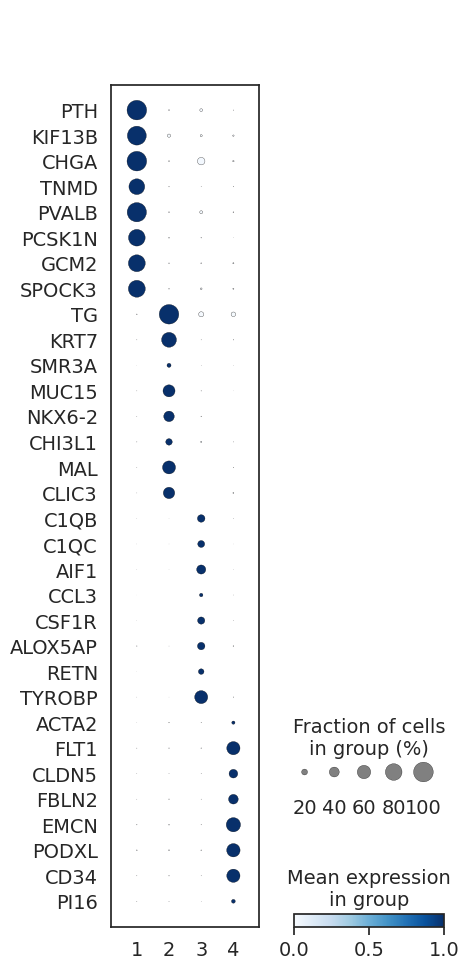

In [75]:
fig, ax =plt.subplots(figsize=(5,10))
axes = sc.pl.dotplot(sdata, groupby='clusters_res_0.1', return_fig=False, ax=ax, swap_axes=True, expression_cutoff=1e-3,
                     var_names=de_gene_set_vis, use_raw=False, standard_scale='var', show=False, cmap='Blues')
axes['mainplot_ax'].set_xticklabels(range(1,sdata.obs['clusters_res_0.1'].unique().shape[0]+1), rotation=0)
axes['mainplot_ax'].set_yticklabels(names_for_dotplot)
    
plt.tight_layout()

fig.savefig('figures/primate_all_cells/markers.png', dpi=500)

/gpfs/gibbs/project/krishnaswamy_smita/av622/conda_envs/gspa/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


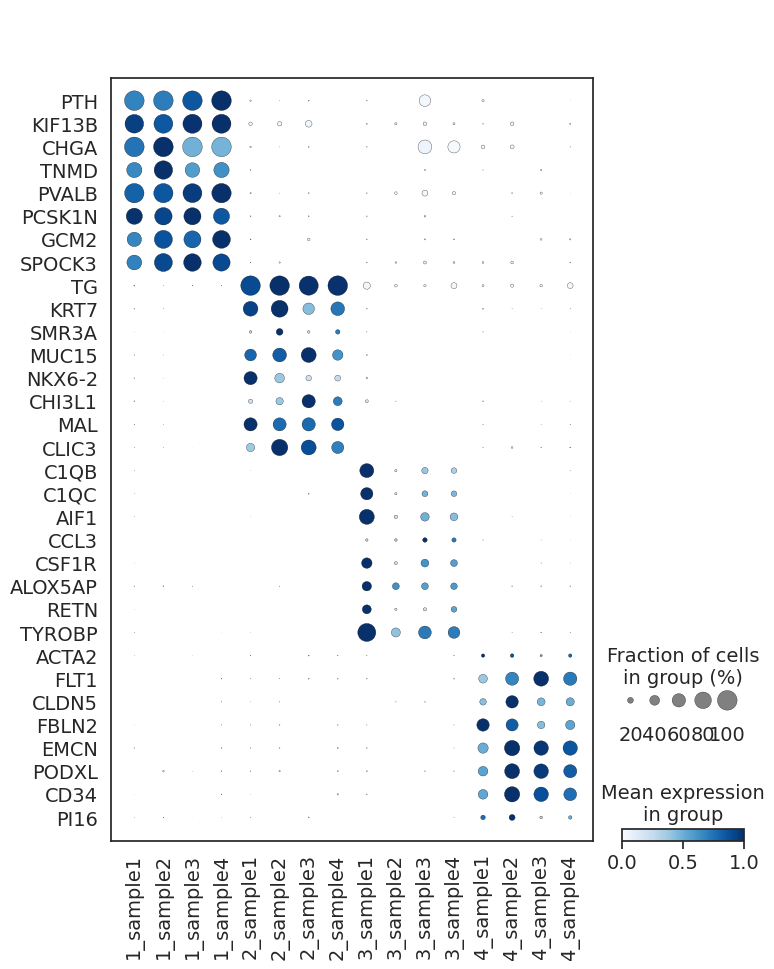

In [76]:
fig, ax =plt.subplots(figsize=(8,10))
axes = sc.pl.dotplot(sdata, groupby=['clusters_res_0.1', 'sample'], return_fig=False, ax=ax, swap_axes=True, expression_cutoff=1e-3,
                     var_names=de_gene_set_vis, use_raw=False, standard_scale='var', show=False, cmap='Blues')
axes['mainplot_ax'].set_yticklabels(names_for_dotplot)

plt.tight_layout()

fig.savefig('figures/primate_all_cells/markers_resolved_by_replicate.png', dpi=500)

## Genome-scale heatmaps

/gpfs/gibbs/project/krishnaswamy_smita/av622/conda_envs/gspa/lib/python3.8/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/gpfs/gibbs/project/krishnaswamy_smita/av622/conda_envs/gspa/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:239: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/gpfs/gibbs/project/krishnaswamy_smita/av622/conda_envs/gspa/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:258: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(


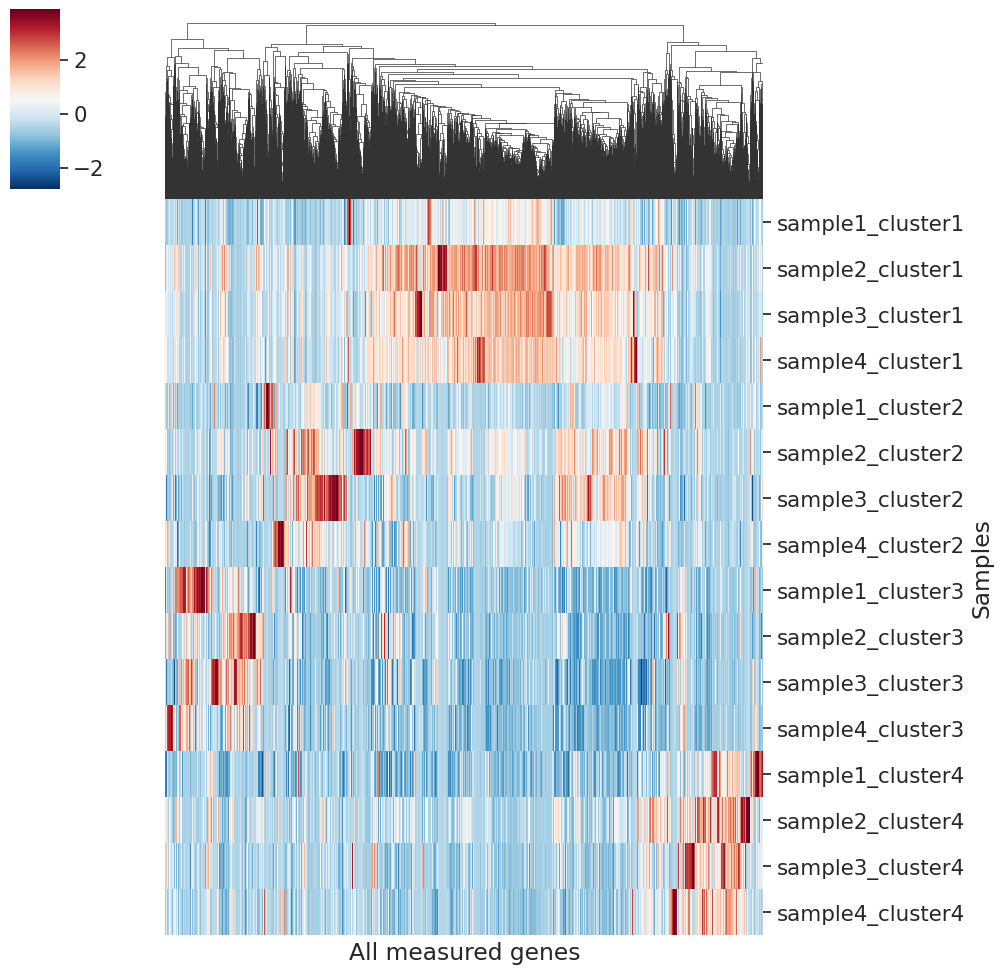

In [77]:
# pre-batch correction

pbs = []
names = []
for cluster in [1,2,3,4]:
    for sample in sdata.obs['sample'].unique():
        sdata_subset = sdata[sdata.obs['sample'] == sample]
        samp_cell_subset = sdata_subset[sdata_subset.obs['clusters_res_0.1'] == str(cluster)]

        rep_adata = sc.AnnData(X = samp_cell_subset.X.mean(axis=0), var=samp_cell_subset.var[[]])
        rep_adata.obs['sample'] = sample
        rep_adata.obs['cluster'] = int(cluster)
        names.append(f'{sample}_cluster{cluster}')
        pbs.append(rep_adata)

pb = sc.concat(pbs)
pb.obs_names = names
pb.X = scale(pb.X)

g= sc.pl.clustermap(pb, row_cluster=False, col_cluster=True, figsize=(10,10), show=False, cmap='RdBu_r', xticklabels=False)
ax = g.ax_heatmap
ax.set_xlabel("All measured genes")
ax.set_ylabel("Samples")
g.savefig('figures/primate_all_cells/clustermap_primate_genome_scale_heatmap.png')

Running MAGIC with `solver='exact'` on 15680-dimensional data may take a long time. Consider denoising specific genes with `genes=<list-like>` or using `solver='approximate'`.
Calculating imputation...


/gpfs/gibbs/project/krishnaswamy_smita/av622/conda_envs/gspa/lib/python3.8/site-packages/magic/magic.py:541: UserWarning: Running MAGIC.transform on different data to that which was used for MAGIC.fit may not produce sensible output, unless it comes from the same manifold.
  warnings.warn(
/gpfs/gibbs/project/krishnaswamy_smita/av622/conda_envs/gspa/lib/python3.8/site-packages/pydeseq2/utils.py:674: RuntimeWarning: invalid value encountered in log
  log_alpha_hat = np.log(alpha_hat)
/gpfs/gibbs/project/krishnaswamy_smita/av622/conda_envs/gspa/lib/python3.8/site-packages/pydeseq2/utils.py:715: RuntimeWarning: invalid value encountered in log
  x0=np.log(alpha_hat),
/gpfs/gibbs/project/krishnaswamy_smita/av622/conda_envs/gspa/lib/python3.8/site-packages/numpy/linalg/linalg.py:2086: RuntimeWarning: invalid value encountered in slogdet
  sign, logdet = _umath_linalg.slogdet(a, signature=signature)
/gpfs/gibbs/project/krishnaswamy_smita/av622/conda_envs/gspa/lib/python3.8/site-packages/pyde

Calculated imputation in 61.40 seconds.


/gpfs/gibbs/project/krishnaswamy_smita/av622/conda_envs/gspa/lib/python3.8/site-packages/scipy/sparse/_index.py:137: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)
/gpfs/gibbs/project/krishnaswamy_smita/av622/conda_envs/gspa/lib/python3.8/site-packages/scipy/sparse/_index.py:137: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)
/gpfs/gibbs/project/krishnaswamy_smita/av622/conda_envs/gspa/lib/python3.8/site-packages/scipy/sparse/_index.py:137: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)
/gpfs/gibbs/project/krishnaswamy_smita/av622/conda_envs/gspa/lib/python3.8/site-packages/scipy/sparse/_index.py:137: SparseEfficiencyWarning: Changing the sparsity structure of a

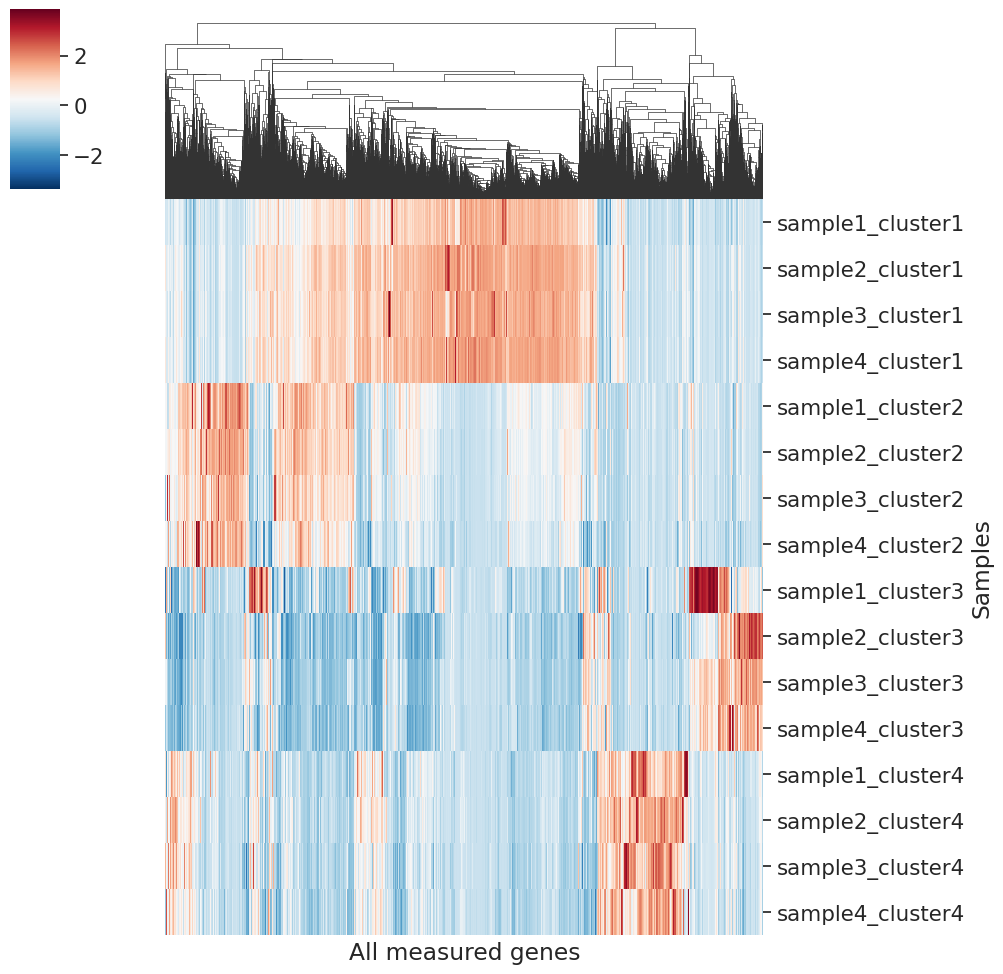

In [80]:
# post-batch correction
# magic simulates changing counts based on new graph (which was used to embed points with PHATE)

magic_op = magic.MAGIC(random_state=42, t=1)
magic_op.graph = G
sdata.layers['X_magic'] = magic_op.transform(sdata.to_df().values, ) 

pbs = []
names = []
for cluster in [1,2,3,4]:
    for sample in sdata.obs['sample'].unique():
        sdata_subset = sdata[sdata.obs['sample'] == sample]
        samp_cell_subset = sdata_subset[sdata_subset.obs['clusters_res_0.1'] == str(cluster)]
        samp_cell_subset.X = samp_cell_subset.layers['X_magic']

        rep_adata = sc.AnnData(X = samp_cell_subset.X.mean(axis=0), var=samp_cell_subset.var[[]])
        rep_adata.obs['sample'] = sample
        rep_adata.obs['cluster'] = int(cluster)
        names.append(f'{sample}_cluster{cluster}')
        pbs.append(rep_adata)

pb = sc.concat(pbs)
pb.obs_names = names
pb.X = scale(pb.X)

g= sc.pl.clustermap(pb, row_cluster=False, col_cluster=True, figsize=(10,10), cmap='RdBu_r', xticklabels=False, show=False)
ax = g.ax_heatmap
ax.set_xlabel("All measured genes")
ax.set_ylabel("Samples")
g.savefig('figures/primate_all_cells/clustermap_primate_bc_genome_scale_heatmap.png')

## Get PTH only

In [102]:
pth = sdata[sdata.obs['clusters_res_0.1'] == '1']
pth.write('../processed_files/4_primate_parathyroid_cells_all_genes.h5ad')

/home/aarthivenkat/.local/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2631: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
